In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear,tanh
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import NearMiss
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import logging
import numpy as np
import matplotlib.pyplot as plt
logging.getLogger("tensorflow").setLevel(logging.ERROR)
from ML_util import *
import graphviz
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image

2022-11-08 20:43:23.172981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_fwf('data.txt')

In [3]:
df.head()

,classID,mX,mXgam,EX_P_Egam,Epis_D__E,Egam,p3L,cospisXga,cospisXga.1,mpisXgam_,...,mcWrongB_.2,mcWrongB_.3,p3pisXgam,cosPhiG1,cospisXga.2,mQXGLw1,weight.1,BDT,LD,prob_LD
0,1,1.114384,1.597457,0.798955,0.104918,0.436953,1.091541,0.898671,0.481301,0.152195,...,3,9,1.567320,-0.883678,0.665655,2.868947,1,-0.079379,0.208172,0.371287
1,1,1.177904,1.341360,-0.089273,0.099872,0.105646,2.069337,0.936480,-0.637876,0.145648,...,4,2,1.593726,0.895740,-0.684525,4.146674,1,-0.325572,0.118564,0.096730
2,1,1.663765,1.745303,1.778954,0.074090,0.157005,1.576703,0.981503,-0.996979,0.144828,...,0,0,1.206983,0.484229,-0.274443,4.848612,1,-0.268796,0.213469,0.393971
3,1,1.364490,1.630229,0.961167,0.101604,0.367103,1.109098,0.954375,-0.810736,0.148047,...,0,0,0.668911,0.629448,0.678082,3.397122,1,-0.238372,0.207760,0.369545
4,1,0.933839,1.396383,0.544535,0.096198,0.333259,1.117779,0.712742,-0.667636,0.145053,...,4,2,0.841355,-0.616161,0.054056,3.099767,1,-0.352616,0.075289,0.049626


In [4]:
df.shape

(178672, 37)

# Load data

In [5]:
X = df.iloc[:,1:]
Y = df.iloc[:,0]

# Clean the data, remove redundant features

In [6]:
X_clean = X.drop(columns = ['weight','weight.1','__run__','__event__','__candida'])

In [7]:
x = X_clean.values  # load the input
y = Y.values # load the target

In [8]:
x.shape

(178672, 31)

In [9]:
y.shape

(178672,)

# Define the normalization function

# The distribution of all features for both zero and one signals.

In [10]:
x0 = x[y==0]
y0 = y[y==0]
print("number of zeros = ", y0.shape[0])

x1 = x[y==1]
y1 = y[y==1]
print("number of ones = ", y1.shape[0])

number of zeros =  14749
number of ones =  163923


In [11]:
n = x0.shape[1]

In [12]:
coa = np.array(X_clean.columns.tolist())

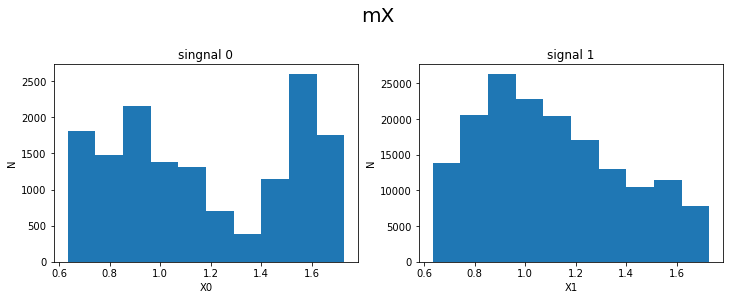

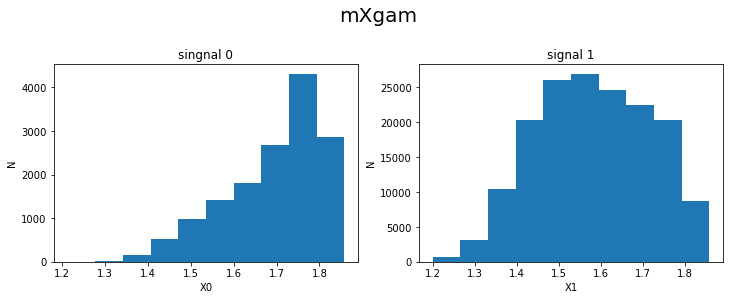

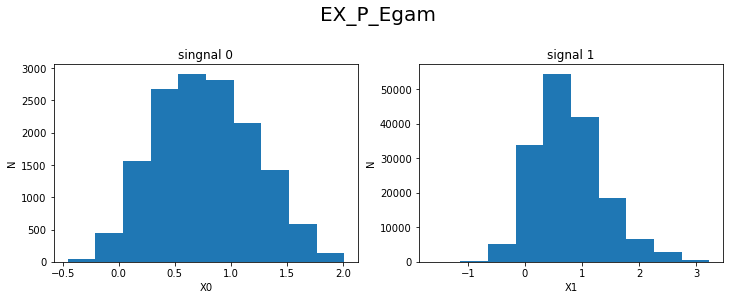

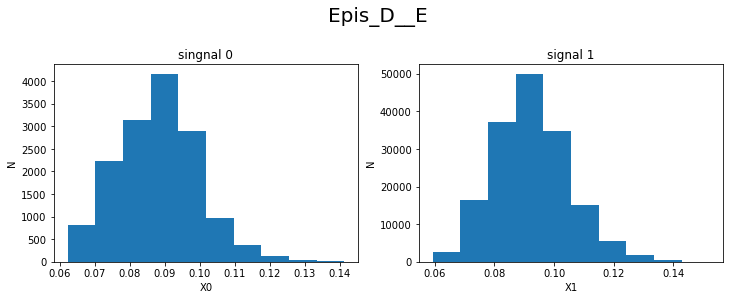

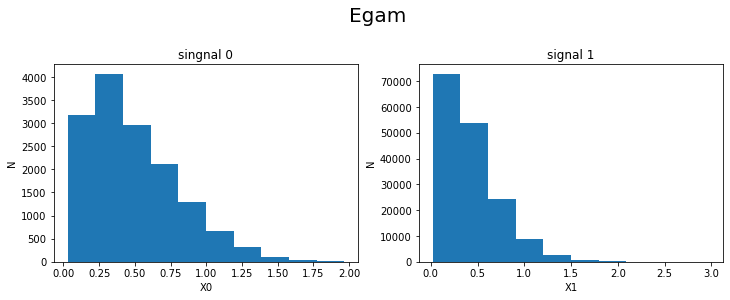

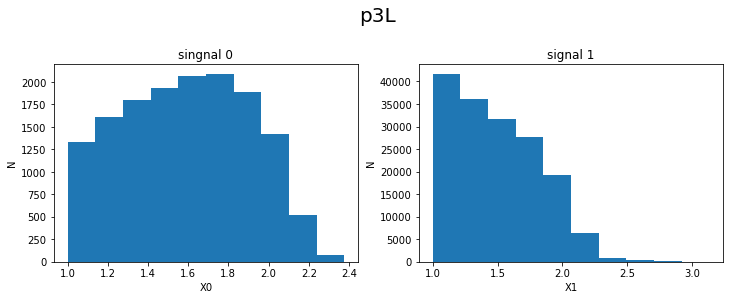

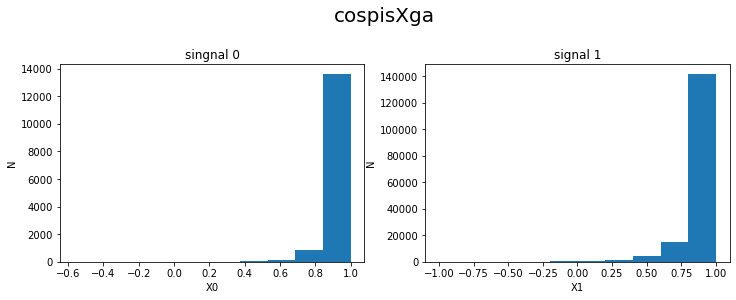

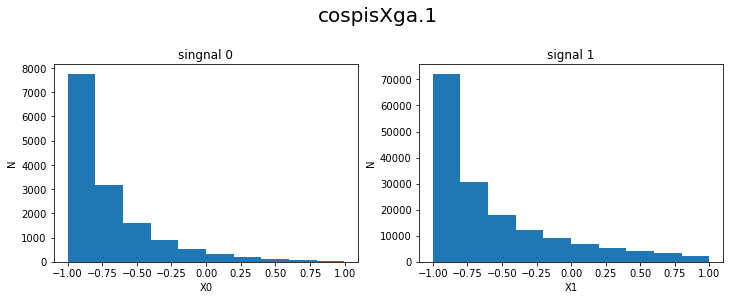

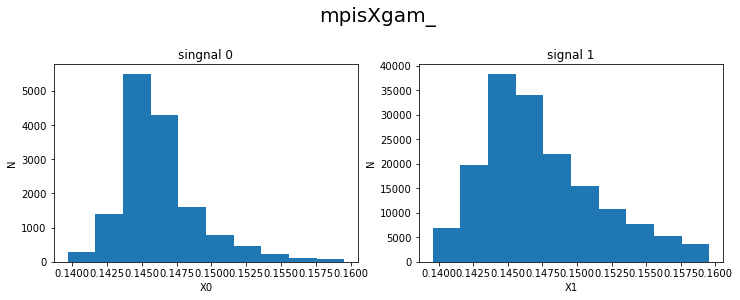

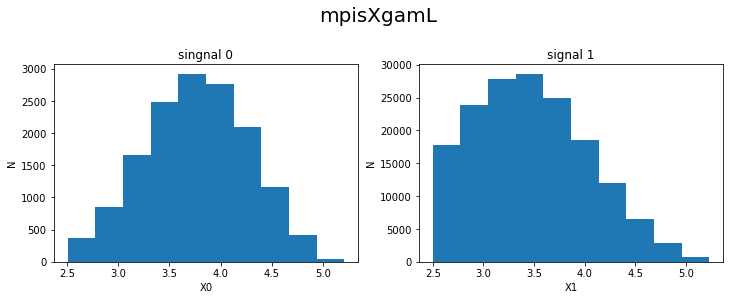

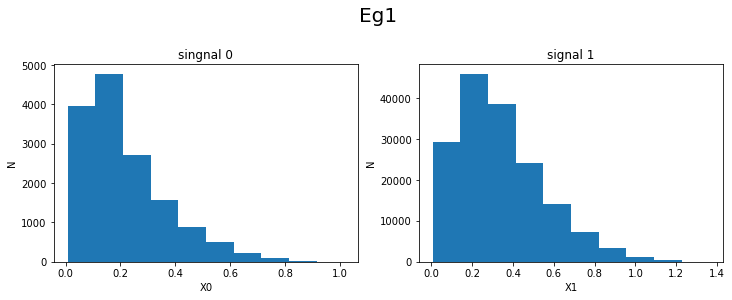

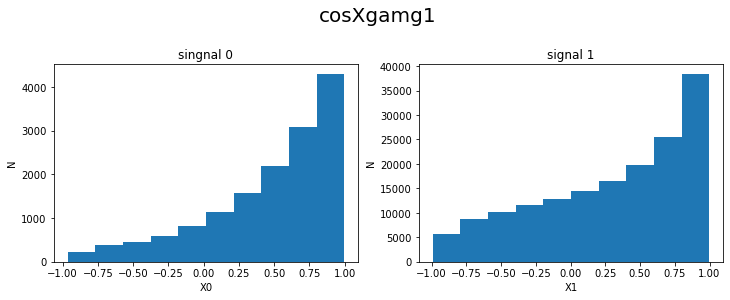

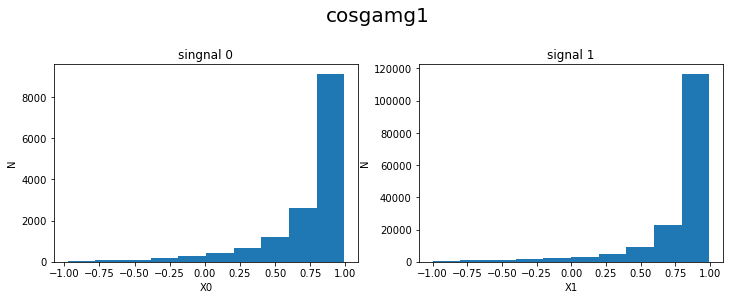

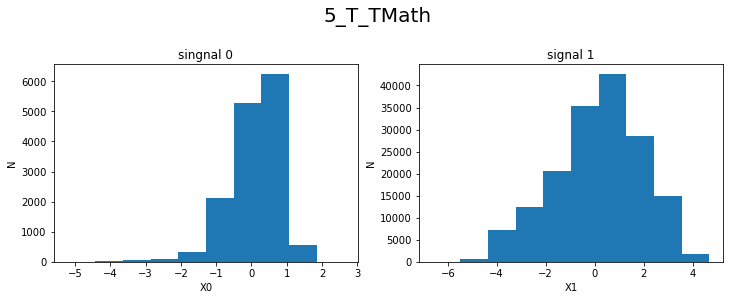

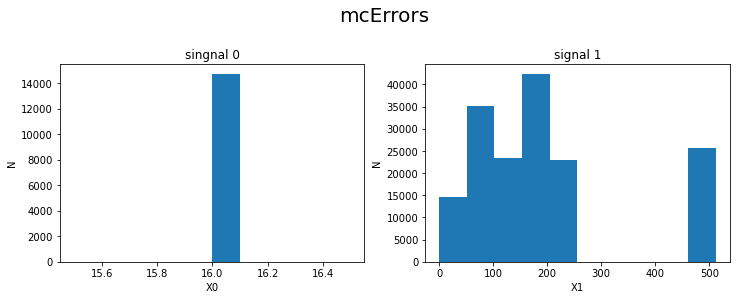

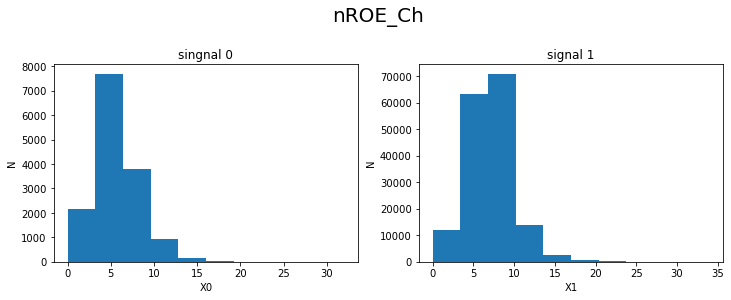

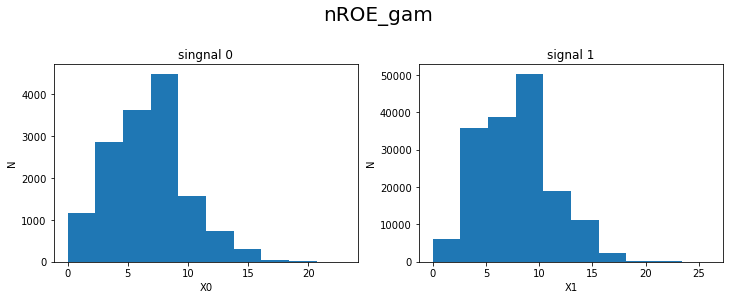

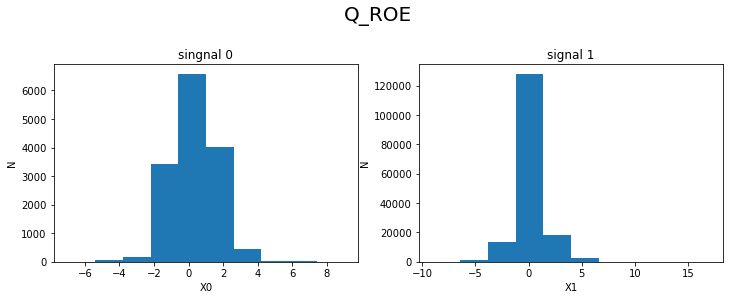

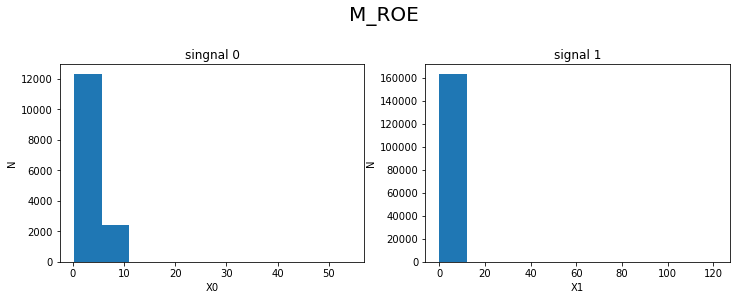

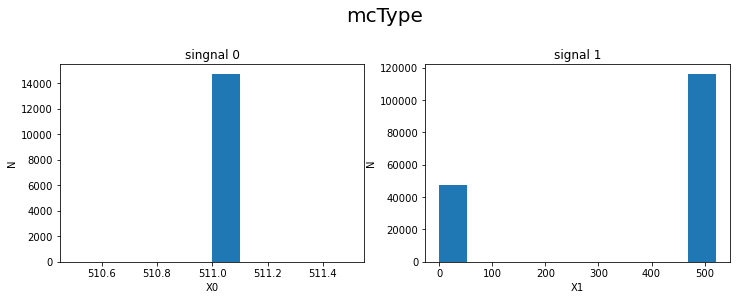

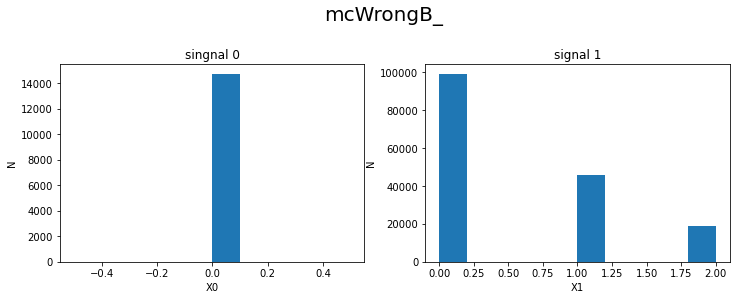

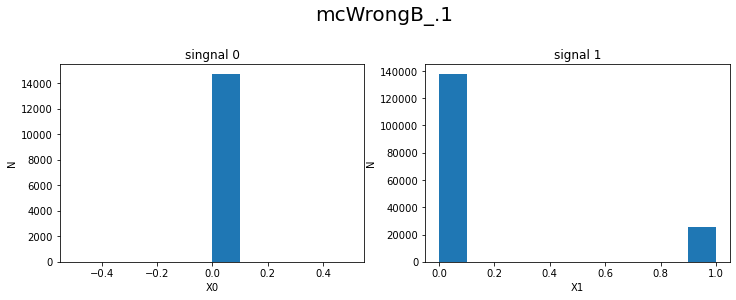

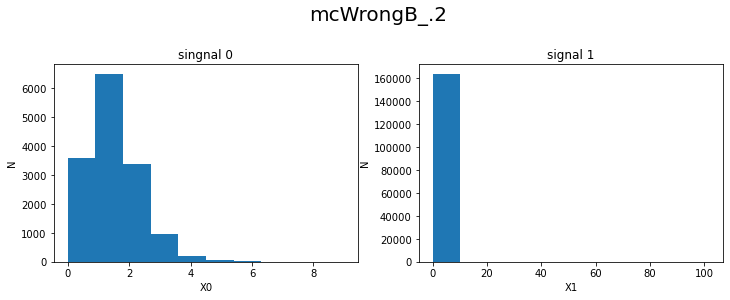

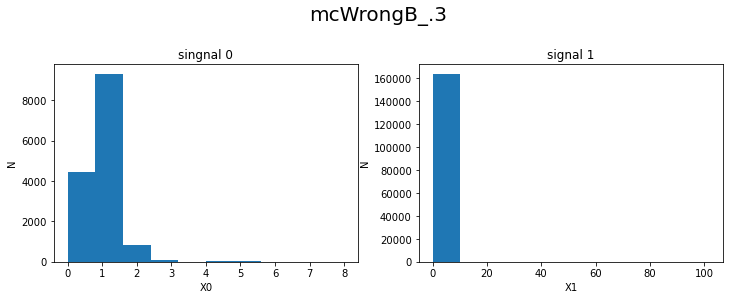

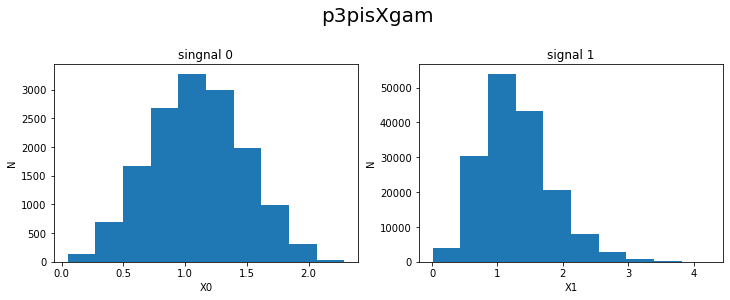

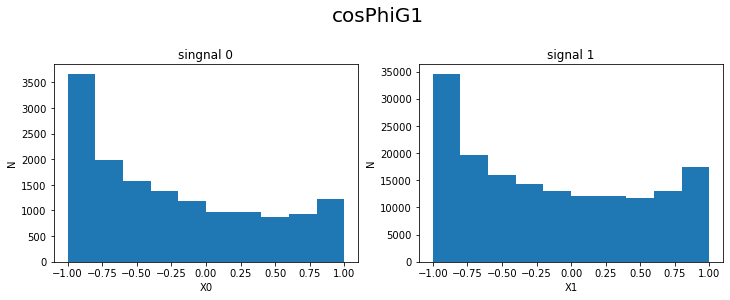

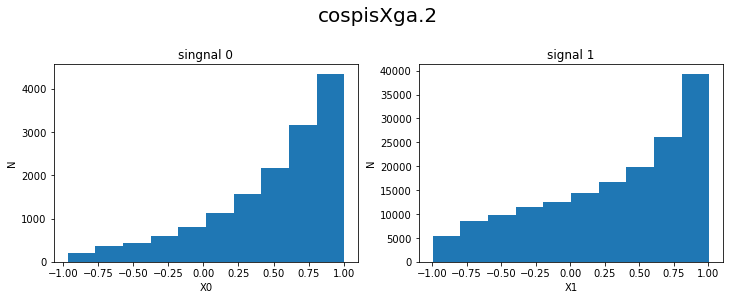

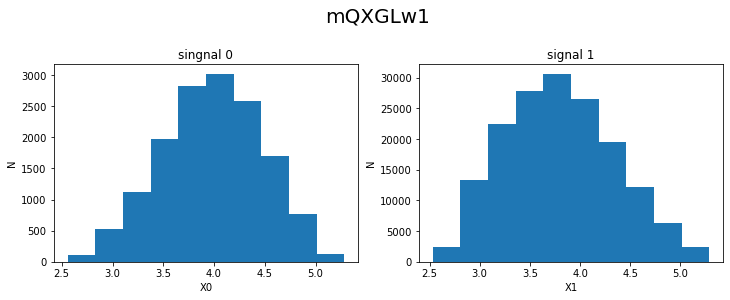

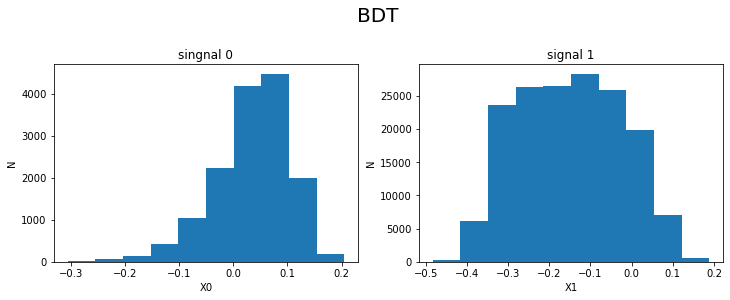

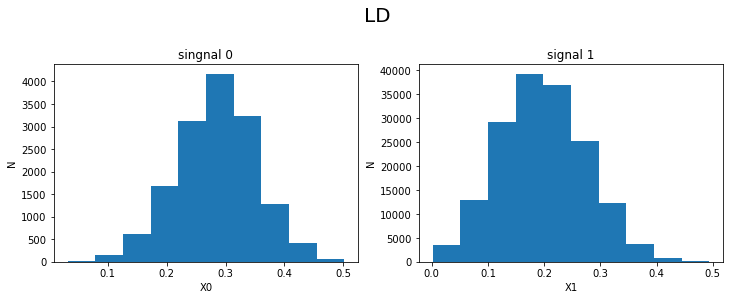

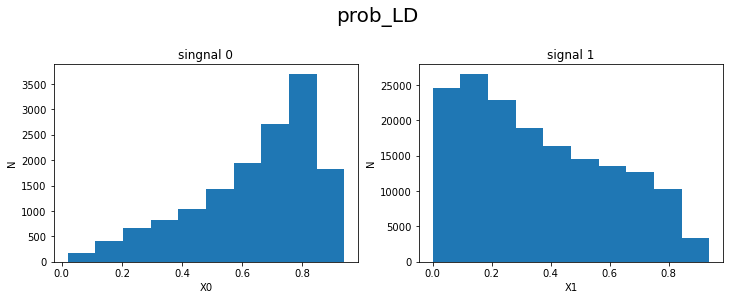

In [13]:
for i in range(n):
    plt.figure(figsize=(12, 8))
    
    plt.suptitle(coa[i],size =20)

    plt.subplot(2,2, 1)
    plt.hist(x0[:,i])
    plt.title('singnal 0')
    plt.ylabel('N')
    plt.xlabel("X0")


    plt.subplot(2,2,2)
    plt.hist(x1[:,i])
    plt.title('signal 1')
    plt.ylabel('N')
    plt.xlabel("X1")
    plt.show()

In [14]:
xx,yy = NearMiss().fit_resample(x,y)

In [15]:
np.mean(yy==0)

0.5

# Applying RandomForrest

In [16]:
xx_tr,xx_te,yy_tr, yy_te = train_test_split(xx,yy,test_size = 0.2)

sc = StandardScaler()
xx_tr_S = sc.fit_transform(xx_tr)
xx_te_S = sc.transform(xx_te)

MM = MinMaxScaler()
xx_tr_M = MM.fit_transform(xx_tr)
xx_te_M = MM.transform(xx_te)

In [17]:
RFclass = RandomForestClassifier( criterion='gini',max_depth = 20,min_samples_leaf=10,max_features='auto')

RFmodel = RFclass.fit(xx_tr_S, yy_tr)

Py_tr_prob = RFmodel.predict_proba(xx_tr_S)
Py_tr = RFmodel.predict(xx_tr_S)

Py_te_prob = RFmodel.predict_proba(xx_te_S)
Py_te = RFmodel.predict(xx_te_S)

In [18]:
ys = Y.replace({1:'detect',0:'non-detect'})

In [19]:
estimator = RFmodel.estimators_[5]
dot_data = export_graphviz(estimator, out_file = 'RF.dot', feature_names = coa\
                    ,class_names = sorted(ys.unique()), rounded = True, filled = True)

s = graphviz.Source.from_file('RF.dot')

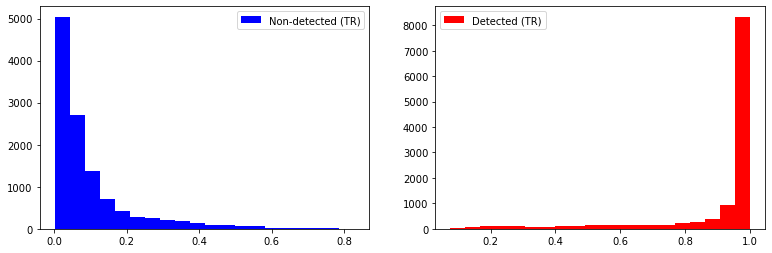

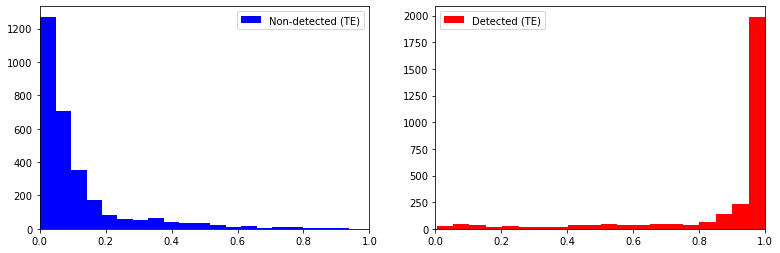

In [20]:
fig = plt.figure(figsize=(13, 9))

plt.subplot(2, 2, 1)
plt.hist(Py_tr_prob[np.where(yy_tr == 0)[0],1],20,color = "blue",)
plt.legend(['Non-detected (TR)'])

plt.subplot(2, 2, 2)
plt.hist(Py_tr_prob[np.where(yy_tr == 1)[0],1],20,color = "red",)
plt.legend(['Detected (TR)'])

plt.show()

fig = plt.figure(figsize=(13, 9))
plt.subplot(2, 2, 1)
plt.hist(Py_te_prob[np.where(yy_te == 0)[0],1],20,color = "blue",)
plt.xlim([0,1])
plt.legend(['Non-detected (TE)'])

plt.subplot(2, 2, 2)
plt.hist(Py_te_prob[np.where(yy_te == 1)[0],1],20,color = "red",)
plt.xlim([0,1])
plt.legend(['Detected (TE)'])
plt.show()

Text(0.5, 1.0, 'Area Under the Curve = 0.993')

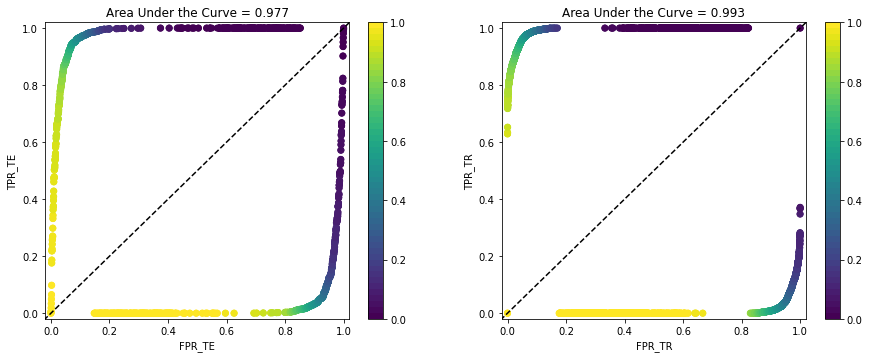

In [21]:
fpr_te = dict()
tpr_te = dict()
T_te = dict()
roc_auc_te = dict()

for i in range(2):
    tpr_te[i], fpr_te[i], T_te[i] = roc_curve(yy_te, Py_te_prob[:,i])
    roc_auc_te[i] = auc(fpr_te[i], tpr_te[i])


    
    
fig = plt.figure(figsize=(15, 12))


plt.subplot(2, 2, 1)
cmap = plt.cm.get_cmap("viridis",50)
plt.scatter(fpr_te[1], tpr_te[1], c=T_te[1],cmap=cmap,vmin=0.,vmax=1)
plt.scatter(fpr_te[0], tpr_te[0], c=T_te[0],cmap=cmap,vmin=0.,vmax=1)
plt.colorbar()
plt.plot([-0.2,1.2],[-0.2,1.2], '--k')
plt.xlim([-.02,1.02])
plt.ylim([-.02,1.02])

plt.xlabel('FPR_TE')
plt.ylabel('TPR_TE')
plt.title('Area Under the Curve = %.3f' %roc_auc_te[0])



fpr_tr = dict()
tpr_tr = dict()
T_tr = dict()
roc_auc_tr = dict()

for i in range(2):
    tpr_tr[i], fpr_tr[i], T_tr[i] = roc_curve(yy_tr, Py_tr_prob[:,i])
    roc_auc_tr[i] = auc(fpr_tr[i], tpr_tr[i])


plt.subplot(2, 2, 2)
cmap = plt.cm.get_cmap("viridis",50)
plt.scatter(fpr_tr[1], tpr_tr[1], c=T_tr[1],cmap=cmap,vmin=0.,vmax=1)
plt.scatter(fpr_tr[0], tpr_tr[0], c=T_tr[0],cmap=cmap,vmin=0.,vmax=1)
plt.colorbar()
plt.plot([-0.2,1.2],[-0.2,1.2], '--k')
plt.xlim([-.02,1.02])
plt.ylim([-.02,1.02])

plt.xlabel('FPR_TR')
plt.ylabel('TPR_TR') 
plt.title('Area Under the Curve = %.3f' %roc_auc_tr[0])


In [22]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 25)
    plt.colorbar()
    plt.tick_marks = np.arange(len(classes))
    plt.xticks(plt.tick_marks, classes, rotation=45)
    plt.yticks(plt.tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size = 20)
    plt.xlabel('Predicted label', size = 20)

Normalized confusion matrix
[[0.96 0.04]
 [0.09 0.91]]


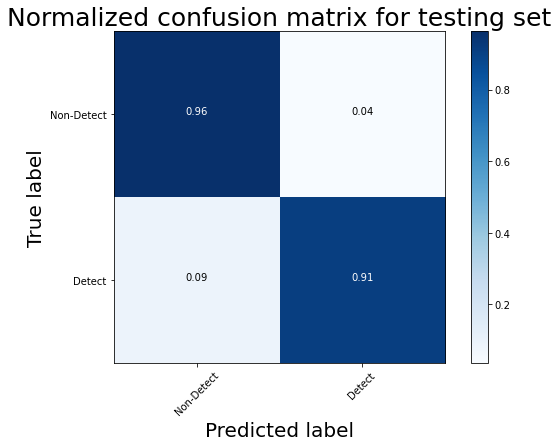

Normalized confusion matrix
[[0.98 0.02]
 [0.07 0.93]]


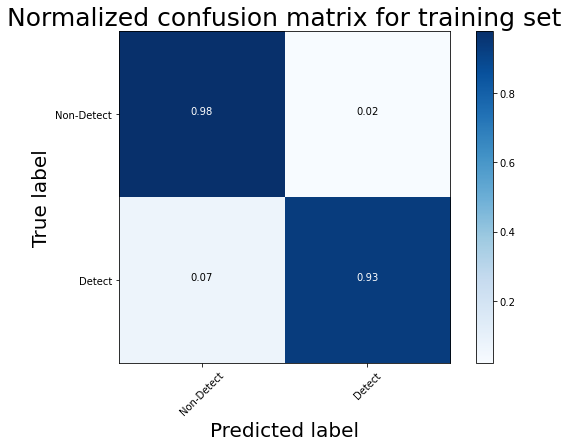

In [23]:
cnf_matrix = confusion_matrix(yy_te,Py_te)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=['Non-Detect', 'Detect'], normalize=True,
                      title='Normalized confusion matrix for testing set')

plt.show()

cnf_matrix = confusion_matrix(yy_tr,Py_tr)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=['Non-Detect', 'Detect'], normalize=True,
                      title='Normalized confusion matrix for training set')

plt.show()

In [24]:
weight = pd.DataFrame(RFclass.feature_importances_)
weight = weight.set_index(coa)
weight = weight.set_axis(['weight'], axis=1)

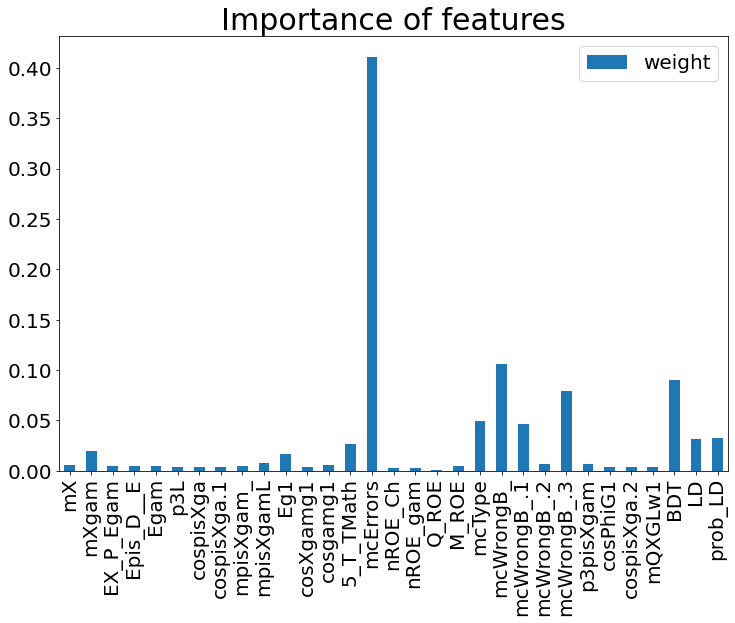

In [25]:
weight.plot(kind='bar',figsize=(12,8),fontsize = 20)
plt.title('Importance of features',size = 30)
plt.legend(fontsize = 20)
plt.show()

# Select significant features

In [26]:
nf =weight.loc[(weight['weight']>0.04)]

In [27]:
nfa = nf.index.values

In [28]:
nfa

array(['mcErrors', 'mcType', 'mcWrongB_', 'mcWrongB_.1', 'mcWrongB_.3',
       'BDT'], dtype=object)

In [29]:
x_n= df[nfa]

In [30]:
x_n.shape

(178672, 6)

In [31]:
x_n.corr()

,mcErrors,mcType,mcWrongB_,mcWrongB_.1,mcWrongB_.3,BDT
mcErrors,1.000000,-0.149345,0.019188,-0.105504,-0.066018,-0.203031
mcType,-0.149345,1.000000,0.321808,0.209028,0.263967,0.229918
mcWrongB_,0.019188,0.321808,1.000000,0.097123,0.389284,-0.071589
mcWrongB_.1,-0.105504,0.209028,0.097123,1.000000,0.160707,0.037496
mcWrongB_.3,-0.066018,0.263967,0.389284,0.160707,1.000000,0.072181
BDT,-0.203031,0.229918,-0.071589,0.037496,0.072181,1.000000


In [32]:
nidx = np.array([X_clean.columns.get_loc(i) for i in nfa])

In [33]:
xn_tr = xx_tr[:,nidx] 
xn_te = xx_te[:,nidx]
xn = xx[:,nidx]

In [34]:
xn.shape

(29498, 6)

In [35]:
xn_tr.shape

(23598, 6)

In [36]:
yy_tr.shape

(23598,)

# Training Neutral Network

In [37]:
x_tr,x_te,y_tr, y_te = train_test_split(x_n.values,y,test_size = 0.2)

In [38]:
sc = StandardScaler()
x_tr_S = sc.fit_transform(x_tr)
x_te_S = sc.transform(x_te)

xn_tr_S = sc.transform(xn_tr)
xn_te_S = sc.transform(xn_te)

MM = MinMaxScaler()
x_tr_M = MM.fit_transform(x_tr)
x_te_M = MM.transform(x_te)

xn_tr_M = MM.transform(xn_tr)
xn_te_M = MM.transform(xn_te)

In [39]:
print("x_tr.shape:", x_tr.shape, "x_te.shape:", x_te.shape)

x_tr.shape: (142937, 6) x_te.shape: (35735, 6)


In [40]:
model = Sequential([
    tf.keras.Input(shape=(x_tr.shape[1],)),
    Dense(24, activation="relu"),
    Dense(12, activation="relu"),
    Dense(1, activation="linear"),
    ] ,name = "Signal_classifier" )

model.compile(loss = BinaryCrossentropy(from_logits=True),
              optimizer = Adam(5e-4),
              metrics=['accuracy'])

2022-11-08 20:44:34.335204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
model.summary()

Model: "Signal_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                168       
                                                                 
 dense_1 (Dense)             (None, 12)                300       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(x_tr_M, y_tr, batch_size = 64, epochs = 50)

Epoch 1/50
2234/2234 [==============================] - 2s 869us/step - loss: 0.1273 - accuracy: 0.9332
Epoch 2/50
2234/2234 [==============================] - 2s 866us/step - loss: 0.0468 - accuracy: 0.9810
Epoch 3/50
2234/2234 [==============================] - 2s 877us/step - loss: 0.0398 - accuracy: 0.9833
Epoch 4/50
2234/2234 [==============================] - 2s 843us/step - loss: 0.0370 - accuracy: 0.9843
Epoch 5/50
2234/2234 [==============================] - 2s 845us/step - loss: 0.0353 - accuracy: 0.9851
Epoch 6/50
2234/2234 [==============================] - 2s 927us/step - loss: 0.0343 - accuracy: 0.9856
Epoch 7/50
2234/2234 [==============================] - 2s 876us/step - loss: 0.0338 - accuracy: 0.9859
Epoch 8/50
2234/2234 [==============================] - 2s 903us/step - loss: 0.0336 - accuracy: 0.9861
Epoch 9/50
2234/2234 [==============================] - 2s 899us/step - loss: 0.0335 - accuracy: 0.9862
Epoch 10/50
2234/2234 [==============================] - 2s 934u

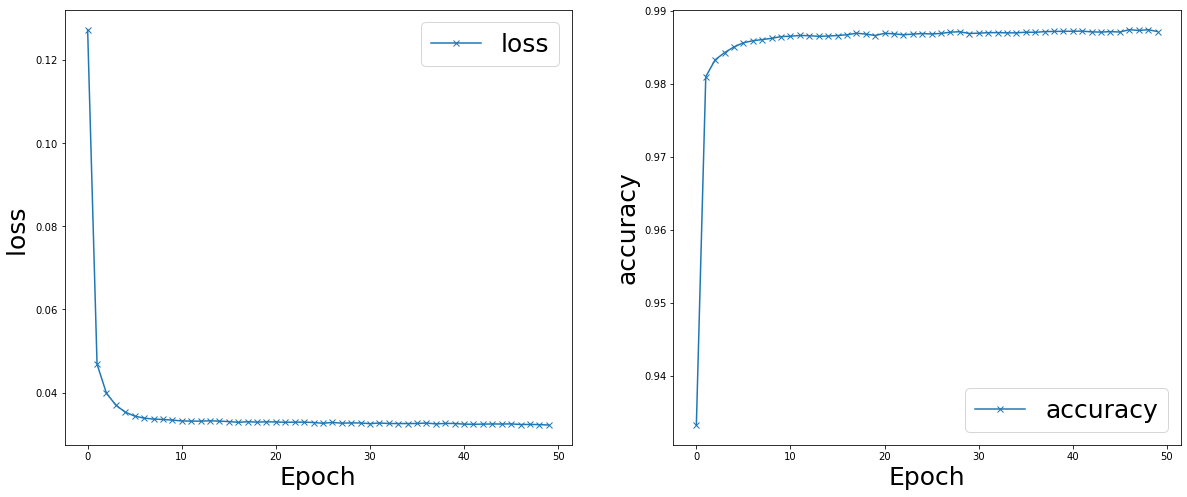

In [43]:
plot_loss_tf(history)

In [44]:
accuracy,recall,precision,Fs = bc_eva(model,x_te_M,y_te)

1117/1117 [==============================] - 1s 602us/step
accuracy =  0.9883307681544704
recall =  0.9917052939741401
precision =  0.9955609980101026
F-score =  0.9936294055639581
